In [1]:
## Standard libraries
import os
import math
import numpy as np 
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

In [2]:
import torch
print("Using torch", torch.__version__)

Using torch 2.0.0+cu117


In [3]:
torch.manual_seed(42) # Setting the seed

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cpu


In [5]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

In [8]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [9]:
import torch.utils.data as data

In [10]:
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [11]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([0.8675, 0.9484]), tensor(0))


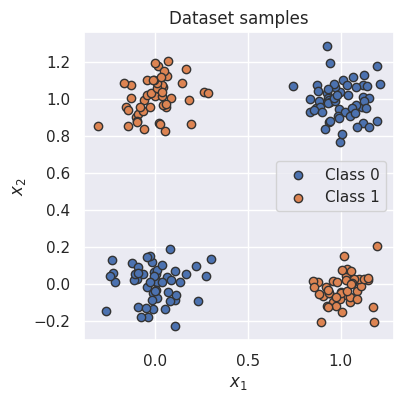

In [12]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
visualize_samples(dataset.data, dataset.label)
plt.show()

In [13]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [14]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

In [15]:
loss_module = nn.BCEWithLogitsLoss()

In [16]:
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [17]:
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [18]:
# Push model to device. Has to be only done once
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [19]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train() 
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:
            
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            
            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())
            
            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero. 
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad() 
            # Perform backpropagation
            loss.backward()
            
            ## Step 5: Update the parameters
            optimizer.step()

In [20]:
train_model(model, optimizer, train_data_loader, loss_module)

  0%|          | 0/100 [00:00<?, ?it/s]

#### Saving a model


In [21]:
state_dict = model.state_dict()

In [22]:
# torch.save(object, filename). For the filename, any extension can be used
torch.save(state_dict, "our_model.tar")

In [23]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("our_model.tar")

# Create a new model and load the state
new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)

<All keys matched successfully>

### Evaluation

In [24]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False) 

In [25]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.
    
    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:
            
            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1
            
            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]
            
    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [26]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.00%


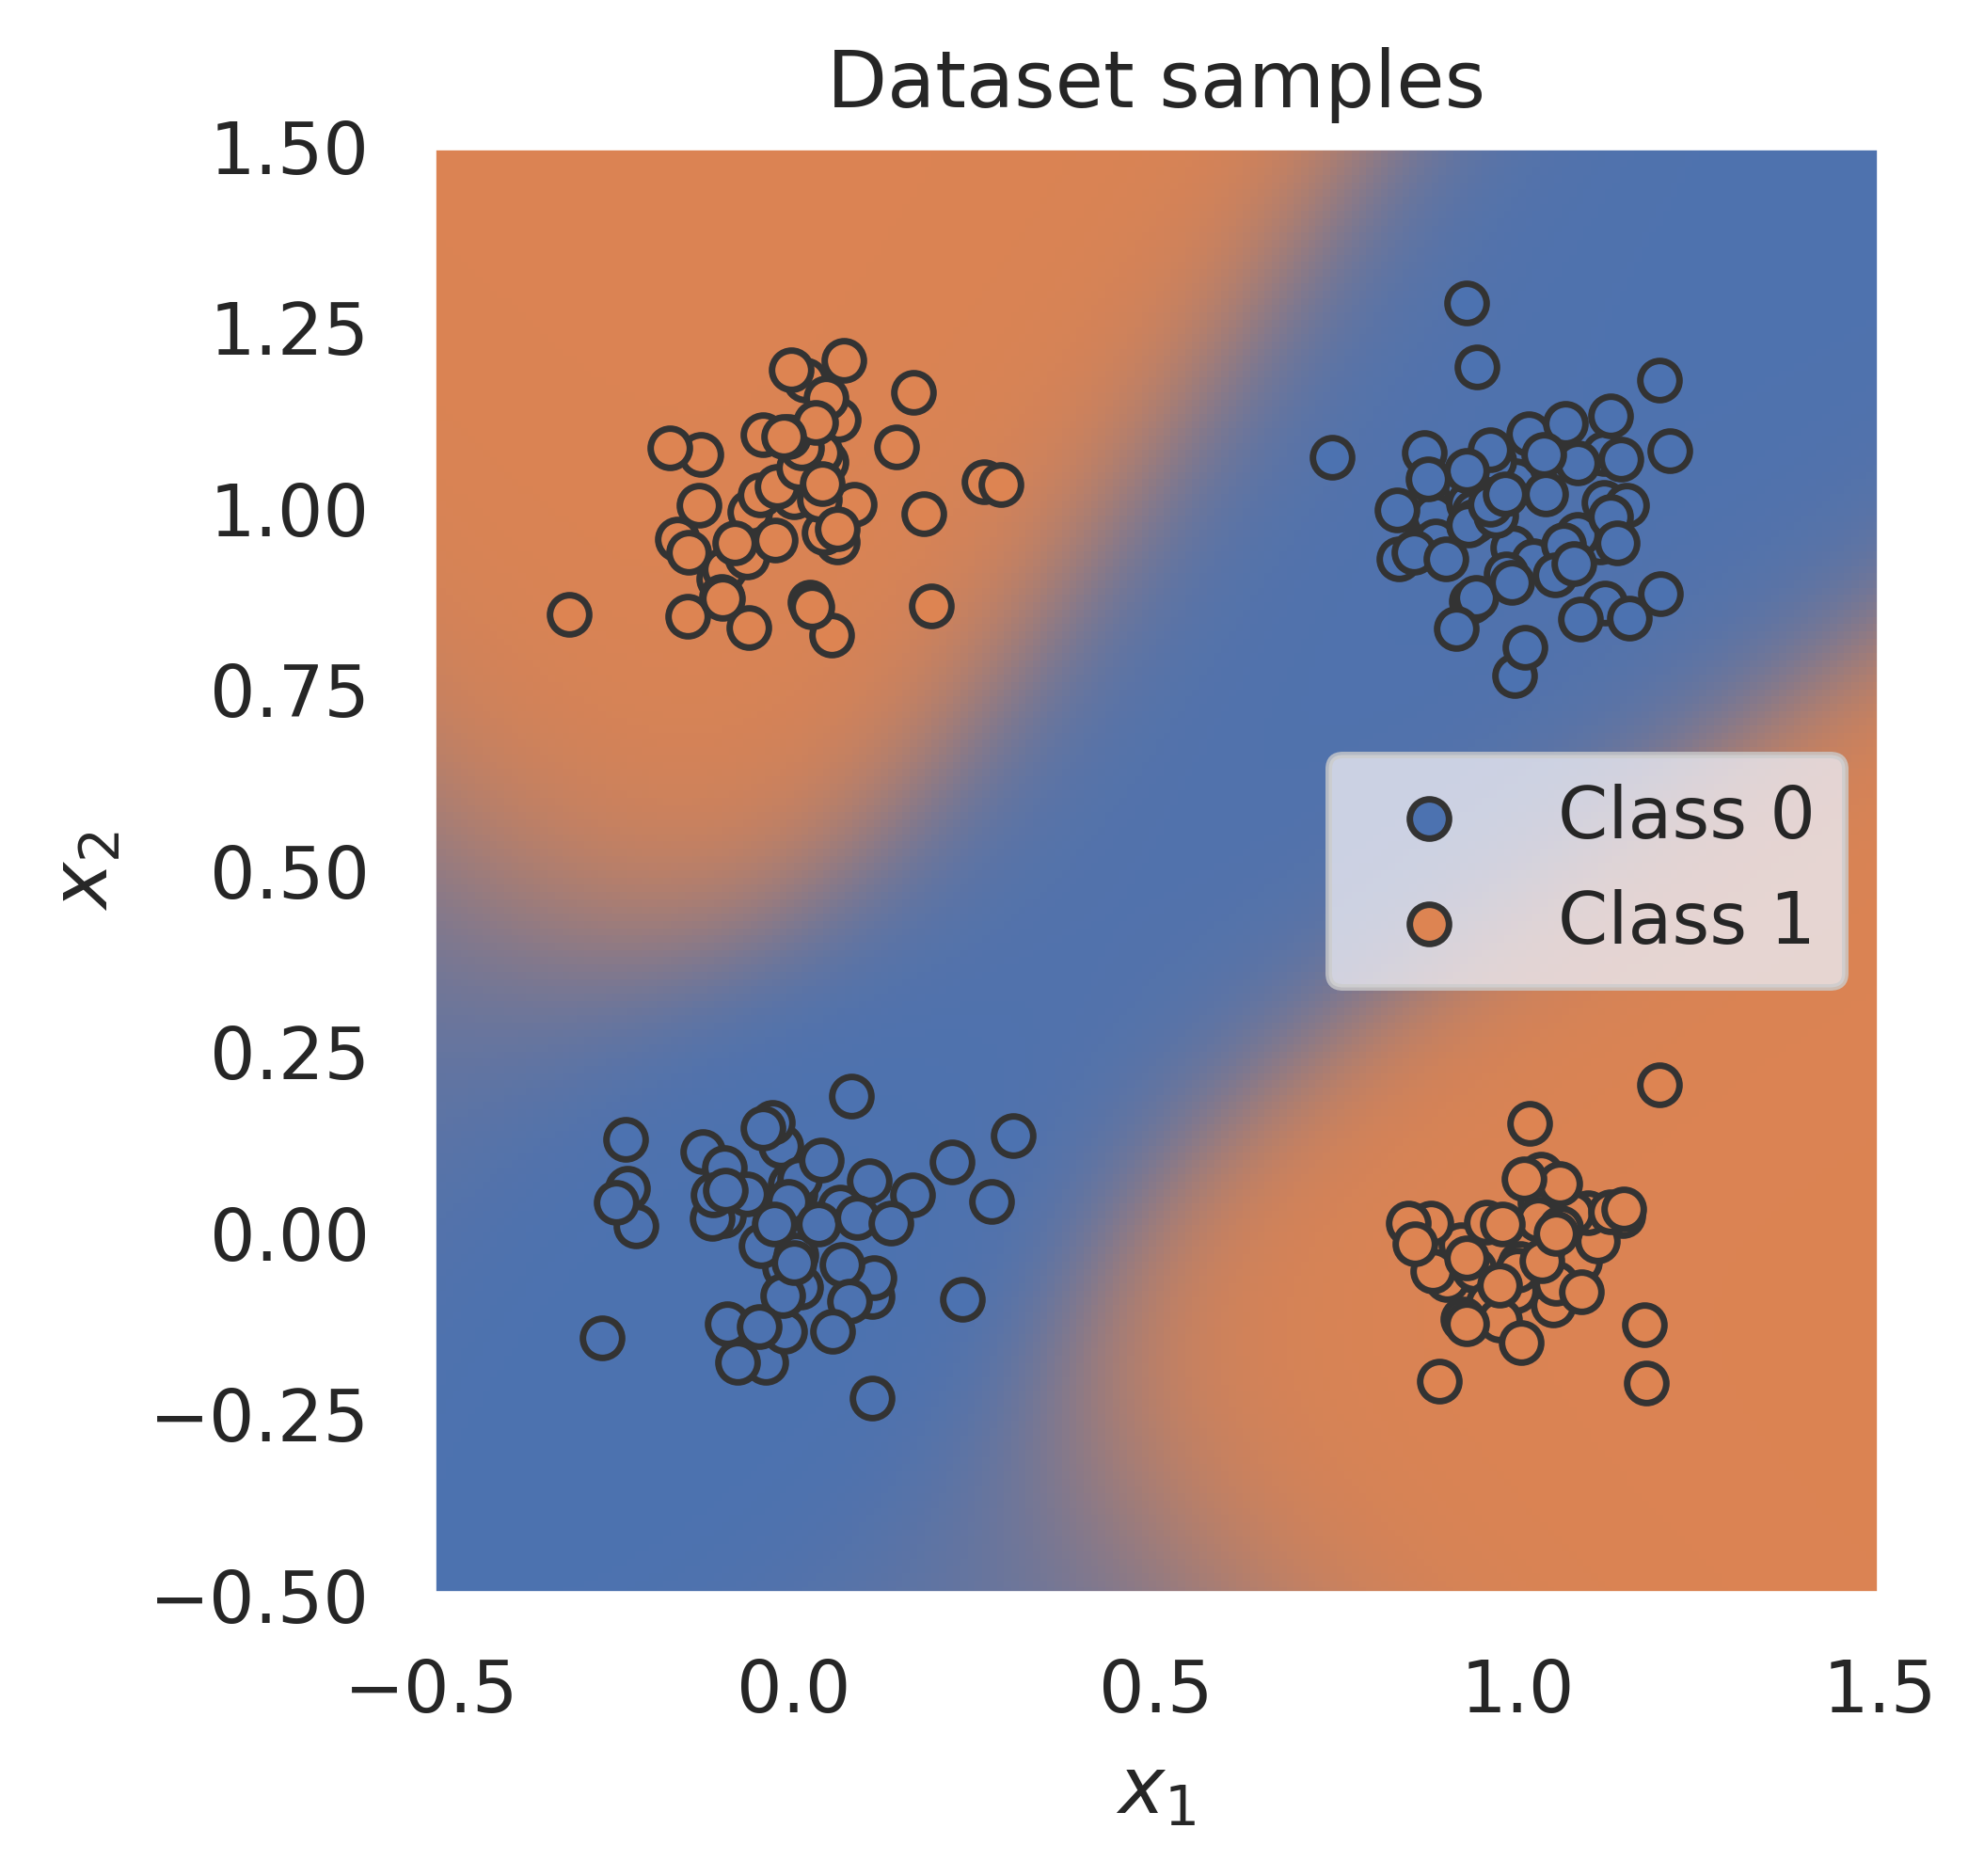

In [27]:
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
    
    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()

### TensorBoard logging

TensorBoard is a logging and visualization tool that is a popular choice for training deep learning models. Although initially published for TensorFlow, TensorBoard is also integrated in PyTorch allowing us to easily use it. First, let's import it below.

In [28]:
# Import tensorboard logger from PyTorch
from torch.utils.tensorboard import SummaryWriter

# Load tensorboard extension for Jupyter Notebook, only need to start TB in the notebook
%load_ext tensorboard

The last line is required if you want to run TensorBoard directly in the Jupyter Notebook. Otherwise, you can start TensorBoard from the terminal.

PyTorch's TensorBoard API is simple to use. We start the logging process by creating a new object, `writer = SummaryWriter(...)`, where we specify the directory in which the logging file should be saved. With this object, we can log different aspects of our model by calling functions of the style `writer.add_...`. For example, we can visualize the computation graph with the function `writer.add_graph`, or add a scalar value like the loss with `writer.add_scalar`. Let's adapt our initial training function with adding a TensorBoard logger below.

In [29]:
def train_model_with_logger(model, optimizer, data_loader, loss_module, val_dataset, num_epochs=100, logging_dir='runs/our_experiment'):
    # Create TensorBoard logger
    writer = SummaryWriter(logging_dir)
    model_plotted = False
    
    # Set model to train mode
    model.train() 
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0.0
        for data_inputs, data_labels in data_loader:
            
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            # For the very first batch, we visualize the computation graph in TensorBoard
            if not model_plotted:
                writer.add_graph(model, data_inputs)
                model_plotted = True
            
            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            
            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())
            
            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero. 
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad() 
            # Perform backpropagation
            loss.backward()
            
            ## Step 5: Update the parameters
            optimizer.step()
            
            ## Step 6: Take the running average of the loss
            epoch_loss += loss.item()
            
        # Add average loss to TensorBoard
        epoch_loss /= len(data_loader)
        writer.add_scalar('training_loss',
                          epoch_loss,
                          global_step = epoch + 1)
        
        # Visualize prediction and add figure to TensorBoard
        # Since matplotlib figures can be slow in rendering, we only do it every 10th epoch
        if (epoch + 1) % 10 == 0:
            fig = visualize_classification(model, val_dataset.data, val_dataset.label)
            writer.add_figure('predictions',
                              fig,
                              global_step = epoch + 1)
    
    writer.close()

Let's use this method to train a model as before, with a new model and optimizer.

In [30]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
train_model_with_logger(model, optimizer, train_data_loader, loss_module, val_dataset=dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

The TensorBoard file in the folder `runs/our_experiment` now contains a loss curve, the computation graph of our network, and a visualization of the learned predictions over number of epochs. To start the TensorBoard visualizer, simply run the following statement:

In [31]:
%tensorboard --logdir runs/our_experiment